In [2]:
#http://www.kamishima.net/sushi/
import numpy as np
import pandas as pd

In [17]:
sushi_data = pd.read_csv('../sushi-recommend/sushi3.idata.csv',delimiter=',')
user_data = pd.read_csv('../sushi-recommend/sushi3.udata.csv',delimiter=',')

In [57]:
sushi_dict = sushi_data.to_dict(orient="index")

In [59]:
sushi_dict[0]["name"]

'ebi'

In [19]:
scores = np.loadtxt('../sushi-recommend/sushi3b.5000.10.score', delimiter=' ')

In [25]:
len(scores)

5000

In [22]:
scores[0].shape

(100,)

In [24]:
scores[0]

array([-1.,  0., -1.,  4.,  2., -1., -1., -1., -1., -1., -1., -1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.,  4., -1.,  2., -1., -1., -1., -1.,
       -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  2., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [42]:
t = scores[0]
average = np.average(t[t>-1])
index = np.where(t>average)
index[0]

array([ 3,  4, 58, 60, 87])

In [60]:
#平均以上の寿司を抽出する(-1を除く)
user_sushi_matrix = []
for rate_sushi in scores:
    average = np.average(rate_sushi[rate_sushi>-1])
    index = np.where(rate_sushi>average)
    index_list = list(index[0])
    res = []
    for i in index_list:
        res.append(sushi_dict[i]["name"])
    user_sushi_matrix.append(res)

In [61]:
user_sushi_matrix

[['ika', 'uni', 'nattou', 'kanpyo_maki', 'tobiuo'],
 ['toro', 'aji', 'kani', 'katsuo', 'kanpyo_maki'],
 ['anago', 'maguro', 'ikura', 'hamachi', 'samon', 'unagi'],
 ['ebi', 'ika', 'uni', 'toro', 'amaebi', 'torigai', 'inari'],
 ['amaebi', 'tarabagani', 'tarako'],
 ['ebi', 'ikura', 'negi_toro'],
 ['maguro', 'uni', 'amaebi', 'hotategai', 'tai', 'unagi'],
 ['ika', 'tako', 'toro', 'amaebi', 'tekka_maki'],
 ['ebi', 'uni', 'chu_toro', 'kani', 'tekka_maki', 'nattou_maki'],
 ['anago', 'ika', 'amaebi', 'awabi', 'negi_toro', 'inari'],
 ['maguro', 'tako', 'toro', 'tai', 'geso'],
 ['amaebi',
  'hamachi',
  'samon',
  'chu_toro',
  'kohada',
  'iwashi',
  'tobiko',
  'toro_samon'],
 ['uni', 'toro', 'hirame', 'kanpachi', 'tsubugai'],
 ['amaebi', 'awabi', 'torigai', 'unagi', 'katsuo', 'sazae', 'kanpyo_maki'],
 ['toro', 'amaebi', 'negi_toro', 'mentaiko', 'kanpyo_maki'],
 ['uni', 'tai', 'akagai', 'kanpachi', 'sayori', 'tarabagani'],
 ['ebi', 'tako', 'ikura', 'hotategai', 'samon', 'shako', 'toro_samon'],


In [93]:
#train
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = gensim.models.Word2Vec(user_sushi_matrix, sg=1, size=25, window=100, hs=0, negative=5, seed=0,iter=30)

In [94]:
model.wv.save_word2vec_format("../sushi-recommend/sushi_vec.txt",binary=False)

In [95]:
#可視化しよう
import sys
sys.path.append(".")
sys.path.append("..")
import os
import gensim
import numpy as np
import factor_rotation as fr
import pandas as pd

def load_word2vec_model():
    print('loading the model...')
    model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_FILE, binary=False)
    print('pre-trained word2vec model loaded...')
    return model


def export_numpy_array(filename, np_array):
    print('exporting the array (' + filename + ') ...')
    np.save(SAVE_PATH + filename, np_array)


def unrotated_reps(model):
    sampled_reps = []; sampled_words = []
    for word in list(model.vocab.keys()):
        if type(word) is not str:
            word = str(word, encoding='utf-8')
        sampled_reps.append(model[word])
        sampled_words.append(word)
    sampled_reps = np.array(sampled_reps)
    sampled_words = np.array(sampled_words)
    print('converting word2vec embeddings to np_array')
    return sampled_reps, sampled_words


def varimax(unrotated):
    print('starting varimax rotation...')
    return fr.rotate_factors(unrotated, 'varimax_CF')


def parsimony(unrotated):
    print('starting factor parsimony rotation...')
    return fr.rotate_factors(unrotated, 'parsimony')


def parsimax(unrotated):
    print('starting factor parsimax rotation...')
    return fr.rotate_factors(unrotated, 'parsimax')


def quartimax(unrotated):
    print('starting factor quartimax rotation...')
    return fr.rotate_factors(unrotated, 'quartimax_CF')


def create_rotated_vec():
    model = load_word2vec_model()
    unrotated, word_list = unrotated_reps(model)
    
    word_list = pd.DataFrame(word_list)
    word_list.to_csv(os.path.join(SAVE_PATH,"word_list.csv"))

    del model
    del word_list

    print('rescaling...')
    scale = .01
    unrotated *= scale
    print(np.max(unrotated))
    print(np.min(unrotated))
    

    print('start rotating...')
    mat_L, mat_T, *_ = method_dic[method_name](unrotated)
    export_numpy_array('{}_axis.npy'.format(method_name), mat_T)
    export_numpy_array('{}_rotated.npy'.format(method_name), mat_L)

In [96]:
MODEL_FILE = '../sushi-recommend/sushi_vec.txt'
SAVE_PATH = '../sushi-recommend/'
method_dic = {"varimax": varimax, "quartimax": quartimax, "parsimony": parsimony, "parsimax":parsimax}
method_name = "parsimax"

create_rotated_vec()

loading the model...
pre-trained word2vec model loaded...
converting word2vec embeddings to np_array
rescaling...
0.00612786
-0.00537818
start rotating...
starting factor parsimax rotation...
exporting the array (parsimax_axis.npy) ...
exporting the array (parsimax_rotated.npy) ...


In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
axis = np.load('../sushi-recommend/parsimax_axis.npy')
rotated = np.load("../sushi-recommend/parsimax_rotated.npy")
word_list = pd.read_csv("../sushi-recommend/word_list.csv")
word_list = list(word_list.iloc[:,1])
np.savetxt('../sushi-recommend/rotated.csv',rotated,delimiter=',')

In [98]:
df = pd.DataFrame(rotated)
df.index = word_list

In [99]:
from tqdm import tqdm_notebook as tqdm
result = []
for i in tqdm(df.columns):
    df.sort_values(i,ascending=False,inplace=True)
    top = df.head(10).index
    result.append(top)

In [100]:
result_df = pd.DataFrame(result)
result_df.to_csv("../sushi-recommend//top10result.csv")

In [101]:
result_df

,0,1,2,3,4,5,6,7,8,9
0,aoyagi,nattou_maki,ika_nattou,ana_kyu_maki,nattou,tako,ume_shiso_maki,hiragai,ume_maki,tekka_maki
1,akagai,suzuki,tamago,iwashi,shiso_maki,toro,unagi,negi_toro_maki,katsuo,geso
2,ishigakidai,iwashi,mirugai,sayori,ankimo,toro_samon,toro,sanma,ume_shiso_maki,botanebi
3,maguro,tako,hotategai,unagi,mentaiko,takuwan_maki,sarada_maki,tarako,sazae,ume_maki
4,aoyagi,akagai,fugu,battera,hiragai,geso,sanma,suzuki,torigai,ika_nattou
5,aji,hamachi,tsubugai,tobiko,nattou,samon,sarada_maki,chu_toro,zuke,mentaiko_maki
6,fugu,suzuki,mirugai,torigai,hokkigai,geso,hiragai,kohada,amaebi,aoyagi
7,kohada,sazae,suzuki,engawa,basashi,shimaaji,negi_toro,sanma,ebi,himo
8,maguro,mentaiko,ebi,amaebi,basashi,sazae,toro,suzuki,negi_toro,tako
9,kohada,suzuki,maguro,sazae,akagai,ebi,unagi,tamago,basashi,sanma


In [102]:
plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定

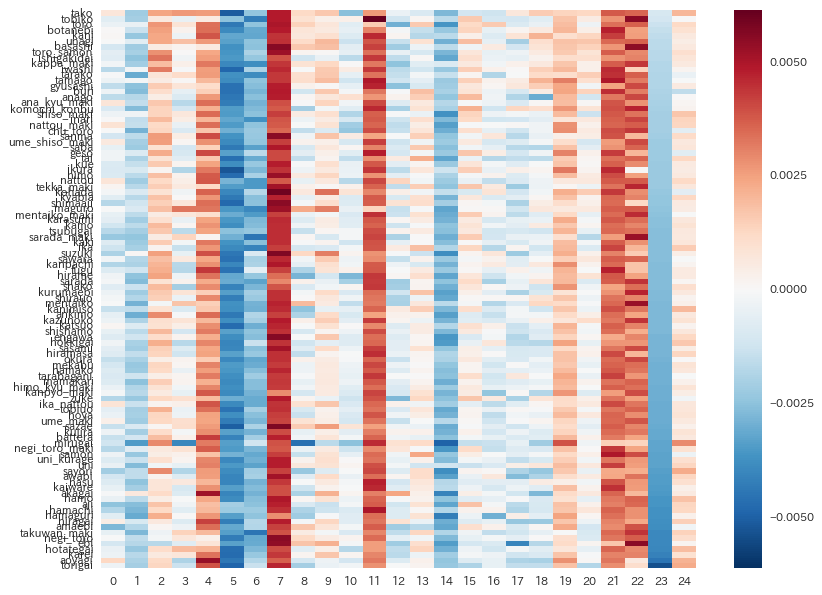

In [106]:
#
df.sort_values(23,ascending=False,inplace=True)
plt.figure(figsize=(12, 9))
sns.heatmap(df)